In [1]:
import serial #导入模块
import threading
import time
import math
import struct
# from . import GPS
STRGLO="" #读取的数据
OP="" #acc or dec
BOOL=True  #读取标志位
MAX_SPEED = 6.0
ACC = 1.0
DELTA_TIME = 0.1
TAO = 1.0
vel_cur = 0.0


def get_vel(vel_relative, dist):
    vel_f = vel_cur
    vel_l = vel_f + vel_relative
    vel_new = min(MAX_SPEED, vel_f + ACC * DELTA_TIME, \
        -ACC*TAO + math.sqrt((ACC*TAO)**2 + vel_f**2 + 2*ACC*dist))
    return vel_new

def get_comm_radius(dist):
    return dist + 500

def pwm_to_vel(pwm):
    return (pwm - 100) / 200 * 0.9
    

def vel_to_pwm(pwm):
    return pwm / 0.9 * 200 + 100

#读数代码本体实现
def ReadData(ser):
    global STRGLO,BOOL, vel_cur
    
    # 循环接收数据，此为死循环，可用线程实现
    cur_time = time.time()
    prev_time = cur_time
    while BOOL:
        if ser.in_waiting:
            STRGLO = ser.read(ser.in_waiting)
            try:
                
                # STRGLO = ser.read(ser.in_waiting)
                
                print(STRGLO.decode('gbk'))
                
                    
                # outfile = open('/home/hu/Desktop/memory_file_sys/stm_data.txt', 'w')
                # outfile.write(STRGLO.decode('gbk'))
                # outfile.close()
            except:
                print('ERROR STM ', STRGLO, STRGLO.hex())


#打开串口
# 端口，GNU / Linux上的/ dev / ttyUSB0 等 或 Windows上的 COM3 等
# 波特率，标准值之一：50,75,110,134,150,200,300,600,1200,1800,2400,4800,9600,19200,38400,57600,115200
# 超时设置,None：永远等待操作，0为立即返回请求结果，其他值为等待超时时间(单位为秒）
def DOpenPort(portx,bps,timeout):
    ret=False
    try:
        # 打开串口，并得到串口对象
        ser = serial.Serial(portx, bps, timeout=timeout)
        #判断是否打开成功
        if(ser.is_open):
           ret=True
           threading.Thread(target=ReadData, args=(ser,)).start()
    except Exception as e:
        print("---异常---:", e)
    return ser,ret

def GPSOpenPort(portx,bps,timeout):
    ret=False
    try:
        # 打开串口，并得到串口对象
        ser = serial.Serial(portx, bps, timeout=timeout)
        #判断是否打开成功
        if(ser.is_open):
           ret=True
           threading.Thread(target=GPS.GPS_run, args=(ser,)).start()
    except Exception as e:
        print("---异常---:", e)
    return ser,ret


#关闭串口
def DColsePort(ser):
    global BOOL
    BOOL=False
    ser.close()



#写数据
def DWritePort(ser,text):
    if type(text) is str:
        result = ser.write(text.encode("gbk"))  # 写数据
    else:
        
        result = ser.write(text)  # 写数据
    return result


#读数据
def DReadPort():
    global STRGLO
    str=STRGLO
    STRGLO=""#清空当次读取
    return str



def read_latest_packet(ser_stm, wifi_path='/home/hu/Desktop/memory_file_sys/wifi.pcap', \
                       lidar_path = '/home/hu/Desktop/memory_file_sys/lidar_data.txt',packet_len=5):
    while(1):
        print('---begin reading lidar---')
        with open(lidar_path, 'r') as in_lidar:
            try:
                l = in_lidar.readline()
                in_lidar.close()
                
                info = l.split()
                dist = float(info[0])
                ang = (float(info[1])) 
                vel_ralative = float(info[2])
                brake_flag = int(info[3])
                B = struct.pack('f', ang)
                print('tmp: ', type(ang), ang, 'B: ', B, B.hex())
                count=DWritePort(ser_stm,'c'.encode('gbk')+B)
                # print('s' + B)
                # count=DWsritePort(ser_stm, B)
                print(f"向STM32 写入 转向系数 {ang}, count={count} ")
                
                comm_radius = get_comm_radius(dist)
                vel_new = get_vel(vel_ralative, dist)
                pwm_vel = vel_to_pwm(vel_new)
                if brake_flag == 1:
                # if True:
                    count=DWritePort(ser_stm,'s')
                else:
                    V = struct.pack('f', pwm_vel)
                    print('V: ', V, V.hex())
                    count=DWritePort(ser_stm,'v'.encode('gbk')+V)
                    # print('s' + B)
                    # count=DWsritePort(ser_stm, B)
                    print(f"向STM32 写入 pwm_vel {pwm_vel}, count={count} ")
                print('---end reading lidar---')
            except Exception as e:
                print(f'---lidar error! {e}---')
        print('---begin reading pcap---')
        # with open(wifi_path, 'rb') as in_wifi:
        #     try:
        #         in_wifi.seek(-packet_len, 2)
        #         tmp = in_wifi.read(packet_len)
        #         print(tmp)
        #         OP=chr(tmp[-5])
        #         count=DWritePort(ser_stm,OP)
        #         print(f"向STM32 写入 加速指令 {OP} ")

        #         in_wifi.close()
        #     except:
        #         print('---wifi error!---')
        # print('---end reading pcap---')
        time.sleep(0.1)

def ReadPcap(ser_stm):
    try:
        threading.Thread(target=read_latest_packet, args=(ser_stm,)).start()
    except Exception as e:
        print("---异常---: ", e)




def main(gps_serial_path = "COM2", stm_serial_path = "COM5"):
    ser_stm,ret_stm=DOpenPort(stm_serial_path,115200,None)
    ser_gps,ret_gps=GPSOpenPort(gps_serial_path,115200,None)
    while(ret_stm==True):#判断串口是否成功打开
        count=DWritePort(ser_stm,"a")
        print("向STM32 写入 加速指令 a ")
        print("GPS.kph:", GPS.kph)
        #DReadPort() #读串口数据
        #DColsePort(ser)  #关闭串口
        time.sleep(10)
        count=DWritePort(ser_stm,"d")
        print("向STM32 写入 减速指令 d ")
        print("GPS.kph:", GPS.kph)
        time.sleep(10) 

def write_to_stm(stm_serial_path, op):
    ser_stm,ret_stm=DOpenPort(stm_serial_path,115200,None)
    while(ret_stm==True):#判断串口是否成功打开
        count=DWritePort(ser_stm, str(op))
        print(f"向STM32 写入 指令 {op}")
        time.sleep(10) 

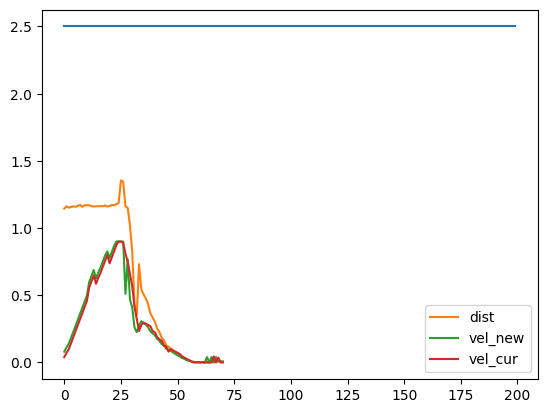

In [37]:
infile = open('/home/hu/Desktop/memory_file_sys/vel_log.txt', 'r')
v1, v2, v3 = [], [], []
dist, vel_new, vel_f, vel_l, vel_cur = [], [], [], [], []
for i, l in enumerate(infile):
    # print
    # (l)
    
    l = l.split(" ")
    if l[0] == 'vel_cur:':
        vel_cur.append(float(l[1]))
    else:
        v1.append(float(l[1]))
        v2.append(float(l[2]))
        dist.append(float(l[3]))
        vel_new.append(float(l[4]))
        vel_f.append(float(l[5]))
        vel_l.append(float(l[6]))
        vel_cur.append(float(l[7]))
    
f'dist:{dist}, vel_new:{vel_new}, vel_f:{vel_f}, vel_l:{vel_l}, vel_cur:{vel_cur}'
import matplotlib.pyplot as plt 
# # plt.plot(v1)
# plt.plot(v1, label='v1')
plt.plot([2.5 for _ in range(200)])
# plt.plot(v2, label='v2')
plt.plot(dist, label='dist')
plt.plot(vel_new, label='vel_new')
# plt.plot(vel_f, label='vel_f')
# plt.plot(vel_l, label='vel_l')
plt.plot(vel_cur, label='vel_cur')

plt.legend()

In [ ]:
stm_serial_path = '/dev/ttyUSB0'
op = 'ls'

ser_stm,ret_stm=DOpenPort(stm_serial_path,115200,None)
write_to_stm(stm_serial_path, op)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/serial/serialposix.py", line 500, in read
    raise SerialException(
serial.serialutil.SerialException: device reports readiness to read but returned no data (device disconnected or multiple access on port?)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_5633/2800721278.py", line 43, in ReadData
  File "/usr/lib/python3/dist-packages/serial/serialposix.py", line 509, in read
    raise SerialException('read failed: {}'.format(e))
serial.serialutil.SerialException: read failed: device reports readiness to read but returned no data (device disconnected or multiple access on port?)


,,,,,,*56
$GPTXT,01,01,01,ANTEN
向STM32 写入 指令 l
NA OK*35

$GNGGA,,,,,,0,00,25.5,,,,,,*64

$GNGLL,,,,,,V,M*79
$GPGSA,A,1,,
,,,,,,,,,,,25.5,25.5,25.5*02
$B
DGSA,A,1,,,,,,,,,,,,,25.5,25.5,2
5.5*13
$GLGSA,A,1,,,,,,,,,,,,,2
5.5,25.5,25.5*1E
$GPGSV,1,1,00*
79
$BDGSV,1,1,00*68
$GLGSV,1,1
,03,78,,,32,70,,,41,86,,,38*6F

$GNRMC,,V,,,,,,,,,,M*4E
$GNVTG,
,,,,,,,,M*2D
$GNZDA,,,,,,*56
$
GPTXT,01,01,01,ANTENNA OK*35

$GNGGA,,,,,,0,00,25.5,,,,,,*64

$GNGLL,,,,,,V,M*79
$GPGSA,A,1,,
,,,,,,,,,,,25.5,25.5,25.5*02
$B
DGSA,A,1,,,,,,,,,,,,,25.5,25.5,2
5.5*13
$GLGSA,A,1,,,,,,,,,,,,,2
5.5,25.5,25.5*1E
$GPGSV,1,1,00*
79
$BDGSV,1,1,00*68
$GLGSV,1,1
,03,78,,,32,70,,,41,86,,,38*6F

$GNRMC,,V,,,,,,,,,,M*4E
$GNVTG,
,,,,,,,,M*2D
$GNZDA,,,,,,*56
$
GPTXT,01,01,01,ANTENNA OK*35

$GNGGA,,,,,,0,00,25.5,,,,,,*64

$GNGLL,,,,,,V,M*79
$GPGSA,A,1,,
,,,,,,,,,,,25.5,25.5,25.5*02
$B
DGSA,A,1,,,,,,,,,,,,,25.5,25.5,2
5.5*13
$GLGSA,A,1,,,,,,,,,,,,,2
5.5,25.5,25.5*1E
$GPGSV,1,1,00*
79
$BDGSV,1,1,00*68
$GLGSV,1,1
,03,78,,,32,70,,,41,8

KeyboardInterrupt: 

$GNGGA,,,,,,0,00,25.5,,,,,,*64

$GNGLL,,,,,,V,M*79
$GPGSA,A,1,,
,,,,,,,,,,,25.5,25.5,25.5*02
$B
DGSA,A,1,,,,,,,,,,,,,25.5,25.5,2
5.5*13
$GLGSA,A,1,,,,,,,,,,,,,2
5.5,25.5,25.5*1E
$GPGSV,1,1,00*
79
$BDGSV,1,1,00*68
$GLGSV,1,1
,03,78,,,32,70,,,41,86,,,38*6F

$GNRMC,,V,,,,,,,,,,M*4E
$GNVTG,
,,,,,,,,M*2D
$GNZDA,,,,,,*56
$
GPTXT,01,01,01,ANTENNA OK*35

$GNGGA,,,,,,0,00,25.5,,,,,,*64

$GNGLL,,,,,,V,M*79
$GPGSA,A,1,,
,,,,,,,,,,,25.5,25.5,25.5*02
$B
DGSA,A,1,,,,,,,,,,,,,25.5,25.5,2
5.5*13
$GLGSA,A,1,,,,,,,,,,,,,2
5.5,25.5,25.5*1E
$GPGSV,1,1,00*
79
$BDGSV,1,1,00*68
$GLGSV,1,1
,02,78,,,32,70,,,41*6B
$GNRMC,,
V,,,,,,,,,,M*4E
$GNVTG,,,,,,,,,
M*2D
$GNZDA,,,,,,*56
$GPTXT,01
,01,01,ANTENNA OK*35

$GNGGA,,,,,,0,00,25.5,,,,,,*64

$GNGLL,,,,,,V,M*79
$GPGSA,A,1,,
,,,,,,,,,,,25.5,25.5,25.5*02
$B
DGSA,A,1,,,,,,,,,,,,,25.5,25.5,2
5.5*13
$GLGSA,A,1,,,,,,,,,,,,,2
5.5,25.5,25.5*1E
$GPGSV,1,1,00*
79
$BDGSV,1,1,00*68
$GLGSV,1,1
,02,78,,,32,70,,,41*6B
$GNRMC,,
V,,,,,,,,,,M*4E
$GNVTG,,,,,,,,,
M*2D
$GNZDA,,,,,,*56
$

: 